# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook:
1. Get probe template
2. **Get the Bragg disks**
3. Calibrate
4. Calculate lattice vectors
5. Fit lattice vectors
6. Calculate strain
7. Visualize strain maps

# Notebook 2: Get the Bragg disks

In this step the Bragg disks are located, as follows:

* For each diffraction pattern:
    * Cross correlate (or hybrid cross-phase correlate) the DP with the probe kernel
    * Get a first guess at Bragg disk positions by identifying positions and intensities of all local maxima
    * Filter out erroneous peaks by removing those too close together, in order of decreasing intensity
* Calculate the average deconvolution
* Optional: ruther refine Bragg peak list
* Save

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from time import time

from py4DSTEM.process.braggdiskdetection import find_Bragg_disks_selected, find_Bragg_disks
from py4DSTEM.process.braggdiskdetection import get_deconvolution, threshold_Braggpeaks
from py4DSTEM.file.datastructure import PointList, PointListArray
from py4DSTEM.file.readwrite import FileBrowser, read, append

In [2]:
# Examine file contents

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
#fp = "/Users/Ben/Work/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
browser = FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    datacube                            DataCube            
   1    probe                               DiffractionSlice    


In [3]:
# Load data

dc = browser.get_dataobject('datacube')
probe = browser.get_dataobject('probe')
probe_kernel = probe.data2D['probe_kernel']
browser.close()

### Test parameters on a few diffraction patterns

Analyzed 3 diffraction patterns in 0h 0m 0s


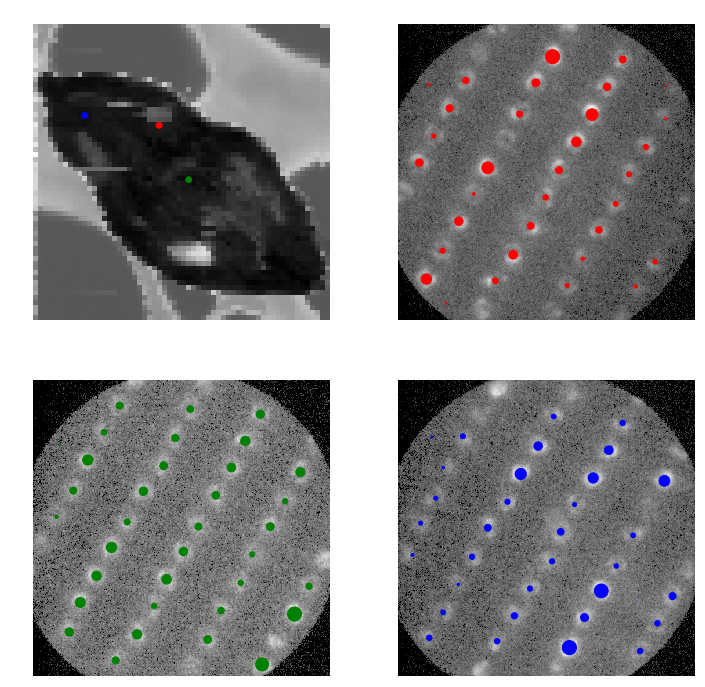

In [4]:
######## Parameters ########

# Select scan positions
Rxs=(20,31,18)
Rys=(25,31,10)

# Peak detection parameters
corrPower = 0.8
sigma = 2
edgeBoundary = 20
maxNumPeaks = 70
minPeakSpacing = 50
minRelativeIntensity = 0.001
subpixel = False

# Display parameters
power=0.3
size_scale_factor = 200       # Set to zero to make all points the same size

############################

# Find peaks
peaks = find_Bragg_disks_selected(dc, probe_kernel, Rxs, Rys,
                                  corrPower=corrPower,
                                  sigma=sigma,
                                  edgeBoundary=edgeBoundary,
                                  minRelativeIntensity=minRelativeIntensity,
                                  minPeakSpacing=minPeakSpacing,
                                  maxNumPeaks=maxNumPeaks,
                                  subpixel=subpixel)

# Show
fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))
ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(Rys,Rxs,color=('r','g','b'))
ax12.matshow(dc.data4D[Rxs[0],Rys[0],:,:]**power)
ax21.matshow(dc.data4D[Rxs[1],Rys[1],:,:]**power)
ax22.matshow(dc.data4D[Rxs[2],Rys[2],:,:]**power)

if size_scale_factor == 0:
    ax12.scatter(peaks[0].data['qy'],peaks[0].data['qx'],color='r')
    ax21.scatter(peaks[1].data['qy'],peaks[1].data['qx'],color='g')
    ax22.scatter(peaks[2].data['qy'],peaks[2].data['qx'],color='b')
else:
    ax12.scatter(peaks[0].data['qy'],peaks[0].data['qx'],color='r',s=size_scale_factor*peaks[0].data['intensity']/np.max(peaks[0].data['intensity']))
    ax21.scatter(peaks[1].data['qy'],peaks[1].data['qx'],color='g',s=size_scale_factor*peaks[1].data['intensity']/np.max(peaks[1].data['intensity']))
    ax22.scatter(peaks[2].data['qy'],peaks[2].data['qx'],color='b',s=size_scale_factor*peaks[2].data['intensity']/np.max(peaks[2].data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

### Find Bragg disks in all diffraction patterns

In [5]:
######## Parameters ########

corrPower = 0.8
sigma = 2
edgeBoundary = 20
maxNumPeaks = 70
minPeakSpacing = 50
minRelativeIntensity = 0.001
subpixel = True
verbose = True

############################

braggpeaks = find_Bragg_disks(dc, probe_kernel,
                              corrPower=corrPower,
                              sigma=sigma,
                              edgeBoundary=edgeBoundary,
                              minRelativeIntensity=minRelativeIntensity,
                              minPeakSpacing=minPeakSpacing,
                              maxNumPeaks=maxNumPeaks,
                              subpixel=subpixel,
                              verbose=verbose)
braggpeaks.name = 'braggpeaks'

Analyzing: |**************************************************| 100.0% Complete
Analyzed 3600 diffraction patterns in 0h 3m 42s


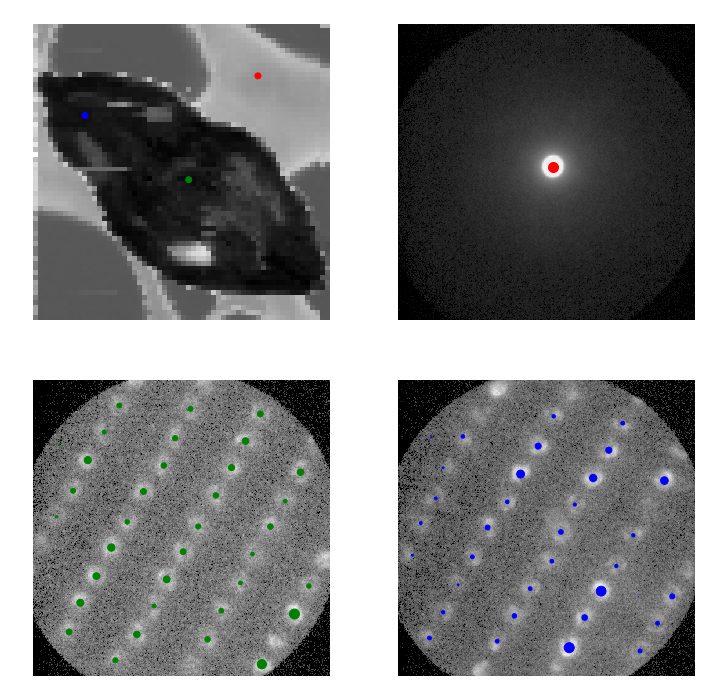

In [6]:
# Show results for a few DPs

xs=(10,31,18)
ys=(45,31,10)
power=0.3

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))

ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(ys,xs,color=('r','g','b'))

ax12.matshow(dc.data4D[xs[0],ys[0],:,:]**power)
ax21.matshow(dc.data4D[xs[1],ys[1],:,:]**power)
ax22.matshow(dc.data4D[xs[2],ys[2],:,:]**power)

peaks0 = braggpeaks.get_pointlist(xs[0],ys[0])
peaks1 = braggpeaks.get_pointlist(xs[1],ys[1])
peaks2 = braggpeaks.get_pointlist(xs[2],ys[2])

ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r',s=100*peaks0.data['intensity']/np.max(peaks0.data['intensity']))
ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g',s=100*peaks1.data['intensity']/np.max(peaks1.data['intensity']))
ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b',s=100*peaks2.data['intensity']/np.max(peaks2.data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()

### Get average deconvolution

In [7]:
# Get deconvolution

deconvolution = get_deconvolution(braggpeaks,dc.Q_Nx,dc.Q_Ny)

/home/ben/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


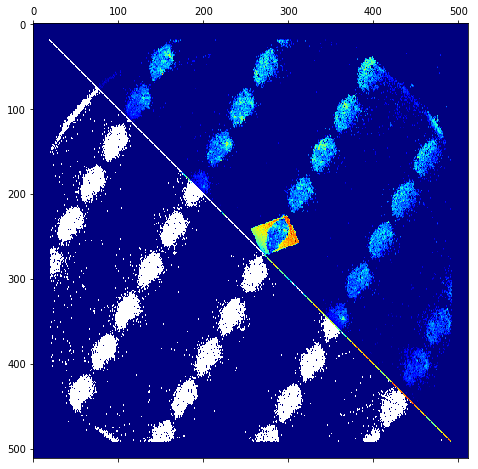

In [8]:
# Show

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(deconvolution**0.25,cmap='jet')
plt.show()

### Save Bragg disk list

In [9]:
deconvolution_diffslice = py4DSTEM.file.datastructure.DiffractionSlice(deconvolution, name='deconvolution_uncorrected')

In [12]:
# Append to processing file

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing_temp.h5"
#savepath = "/Users/Ben/Work/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
#append([braggpeaks, deconvolution_diffslice], fp)
py4DSTEM.file.readwrite.save(braggpeaks, fp, save_metadata=False)

Creating file /home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing_temp.h5...
Done.


### Apply further thresholding

Optionally, we can copy the Bragg peak list just generated and then apply more stringent thresholds.

In [10]:
# Remove points based on new peak spacing or minimum relative intensity thresholds

maxNumPeaks = 60
minPeakSpacing = 50
minRelativeIntensity = 0.001

braggpeaks_thresh = braggpeaks.copy(name='Braggpeaks')  # Create a copy of the PointListArray to further threshold
braggpeaks_thresh = threshold_Braggpeaks(braggpeaks_thresh,
                                         minRelativeIntensity=minRelativeIntensity,
                                         minPeakSpacing=minPeakSpacing,
                                         maxNumPeaks=maxNumPeaks)

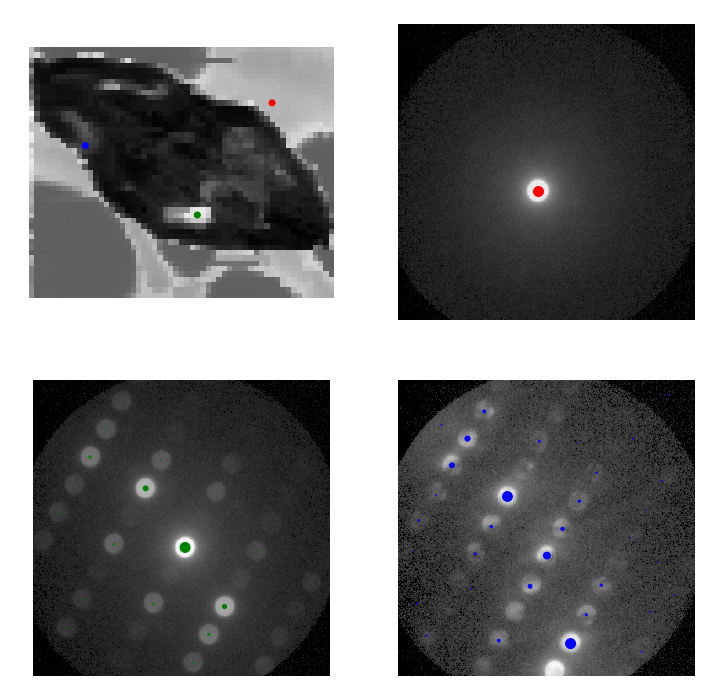

In [11]:
# Show newly thresholded results for a few DPs

xs=(10,31,18)
ys=(45,31,10)
power=0.3
size_scale_factor=100

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(12,12))

ax11.matshow(np.average(dc.data4D,axis=(2,3)))
ax11.scatter(ys,xs,color=('r','g','b'))

ax12.matshow(dc.data4D[xs[0],ys[0],:,:]**power)
ax21.matshow(dc.data4D[xs[1],ys[1],:,:]**power)
ax22.matshow(dc.data4D[xs[2],ys[2],:,:]**power)

peaks0 = braggpeaks_thresh.get_pointlist(xs[0],ys[0])
peaks1 = braggpeaks_thresh.get_pointlist(xs[1],ys[1])
peaks2 = braggpeaks_thresh.get_pointlist(xs[2],ys[2])

if size_scale_factor == 0:
    ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r')
    ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g')
    ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b')
else:
    ax12.scatter(peaks0.data['qy'],peaks0.data['qx'],color='r',s=size_scale_factor*peaks0.data['intensity']/np.max(peaks0.data['intensity']))
    ax21.scatter(peaks1.data['qy'],peaks1.data['qx'],color='g',s=size_scale_factor*peaks1.data['intensity']/np.max(peaks1.data['intensity']))
    ax22.scatter(peaks2.data['qy'],peaks2.data['qx'],color='b',s=size_scale_factor*peaks2.data['intensity']/np.max(peaks2.data['intensity']))

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')
plt.show()